# 2) Features and aggregation (Seg=48)

This notebook contains instructions and command cells only; the logic lives in `src/` and `scripts/`.
Make sure parsing and reconstruction have been completed (see the 1_* notebook).


In [128]:
# Repository path
import os
REPO_DIR = '/content/drive/MyDrive/00_EUREX/eurex-liquidity-demo'
assert os.path.exists(REPO_DIR), f'Repo not found: {REPO_DIR}'
REPO_DIR


'/content/drive/MyDrive/00_EUREX/eurex-liquidity-demo'

## Load aggregated results into DuckDB warehouse

Once the aggregation script is implemented, run the command below to import Parquet
outputs into DuckDB and create analysis views.

In [129]:
# Import Parquet into DuckDB and create analysis views (placeholder; run after scripts are implemented)
!python "{REPO_DIR}/scripts/build_duckdb.py" --seg 48 --freq 1s 5s 1m


## Fetch interest rate data (ECB SDW)

- In the ECB Data Browser, select the desired series and copy the SDMX-JSON link.
- Paste into `ESTR_URL` (overnight €STR, daily) and optionally `YC_URL` (zero-coupon yield curve) below.
- The script writes to DuckDB tables: `eurex.dim_estr` and `eurex.dim_yield_curve`.

Note: If a URL is not provided, that source is skipped. IV inversion falls back to `r = 0.0` if no rates are available.

In [130]:
# Fetch rates and load into DuckDB (paste ECB SDW SDMX-JSON URLs first)
# Tip: In the ECB Data Browser, select the €STR or yield curve series → Download → SDMX-JSON → copy the URL.

# Required/optional URLs (leave empty to skip)
ESTR_URL = ""  # €STR (daily)
YC_URL   = ""  # Zero-coupon yield curve (optional)
YC_MATURITY_COL = ""  # If auto-detection fails, set e.g. 'MATURITY' or 'TENOR'

import os
repo_dir = REPO_DIR
db_path  = os.path.join(REPO_DIR, 'warehouse', 'eurex.duckdb')

!python "{repo_dir}/scripts/fetch_rates.py" \
  --db "{db_path}" \
  --estr-url "{ESTR_URL}" \
  --yc-url "{YC_URL}" \
  --yc-maturity-col "{YC_MATURITY_COL}"


[INFO] DuckDB path: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb
[WARN] --estr-url not provided; skipping €STR
[WARN] --yc-url not provided; skipping Yield Curve
[INFO] Done.


In [131]:
# === Quick L1 Data Preview (from demo window) ===
import duckdb
import os

# Connect to DuckDB
db_path = os.path.join(REPO_DIR, 'warehouse', 'eurex.duckdb')
con = duckdb.connect(db_path)

# Load demo L1 data (from 10-min window) into a temporary table
csv_path = f"{REPO_DIR}/data_samples/48-FSTK-ADSG/l1/l1_snapshots_seg48.csv"          # Updated path
if os.path.exists(csv_path):
    con.execute(f"CREATE TEMP TABLE l1_data AS SELECT * FROM read_csv_auto('{csv_path}')")
    
    # Explore the data
    print("L1 Snapshots Preview (from organized structure):")
    print(con.execute("SELECT * FROM l1_data ORDER BY ts_ns LIMIT 10").df())
else:
    print(f"⚠️  L1 data not found at: {csv_path}")
    print("Run L1 construction first in Notebook 1")

con.close()

L1 Snapshots Preview (from organized structure):
                 ts_ns  best_bid  bid_size  best_ask  ask_size  action  \
0  1606809697524721888  269.9571         5       NaN       NaN       0   
1  1606809697524721888  269.9571         5  270.9045       5.0       0   
2  1606809778487620430  269.8074         5  270.9045       5.0       0   
3  1606809778487620430  269.8074         5  270.7542       5.0       0   
4  1606809810878532690  269.9571         5  270.7542       5.0       0   
5  1606809810878532690  269.9571         5  270.9045       5.0       0   
6  1606809816428848771  270.1068         5  270.9045       5.0       0   
7  1606809816428848771  270.1068         5  271.0547       5.0       0   
8  1606809824923112496  269.9571         5  271.0547       5.0       0   
9  1606809824923112496  269.9571         5  270.9045       5.0       0   

   security_id  
0      2788279  
1      2788279  
2      2788279  
3      2788279  
4      2788279  
5      2788279  
6      2788279  


In [132]:
# === Full-Day L1 Aggregation to 1-Second Metrics ===
# Aggregate L1 snapshots from full daily data into 1-second liquidity metrics

SEG = 48
L1_CSV = f"{REPO_DIR}/data_samples/48-FSTK-ADSG/l1/l1_snapshots_seg{SEG}.csv"           # Updated path
DI_FULL = f"{REPO_DIR}/data_raw/Sample_Eurex_20201201_10MktSegID/48/DI_48_20201201.csv"  # Complete daily file
MAPPING_JSON = f"{REPO_DIR}/data_samples/48-FSTK-ADSG/raw/di_mapping_seg48.json"         # Updated path
OUT_DIR = f"{REPO_DIR}/data_samples/48-FSTK-ADSG"

print(f"📊 Aggregating full-day L1 data to 1-second metrics")
print(f"Input: {L1_CSV}")
print(f"Output: {OUT_DIR}/l1/")
print(f"Expected: Hundreds of seconds with bid-ask spreads, imbalance, microprice")

!python "{REPO_DIR}/scripts/aggregate_1s.py" \
  --seg {SEG} \
  --l1 "{L1_CSV}" \
  --di "{DI_FULL}" \
  --mapping "{MAPPING_JSON}" \
  --out "{OUT_DIR}"

📊 Aggregating full-day L1 data to 1-second metrics
Input: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l1/l1_snapshots_seg48.csv
Output: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l1/
Expected: Hundreds of seconds with bid-ask spreads, imbalance, microprice
[OK] Wrote: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l1/l1_agg_1s_seg48.parquet rows= 33
[OK] Wrote: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l1/l1_agg_1s_seg48.csv rows= 33

[Preview] First 6 rows:
   security_id        ts_s  best_bid  ...  microprice  update_count  cancel_count
0      2788279  1606809697  269.9571  ...   270.43080             2             0
1      2788279  1606809778  269.8074  ...   270.28080             2             0
2      2788279  1606809810  269.9571  ...   270.43080             4             0
3      2788279  1606809816  270.1068  ...   270.58075             2  

In [133]:
# === Full-Day L5 Multi-Level Aggregation to 1-Second Metrics ===
# Aggregate L5 snapshots from full daily data into enhanced 1-second liquidity metrics
# Provides depth analysis: total volumes, weighted prices, L1-L5 ratios

SEG = 48
L5_CSV = f"{REPO_DIR}/data_samples/48-FSTK-ADSG/l5/l5_snapshots_seg{SEG}.csv"           # L5 snapshots
DI_FULL = f"{REPO_DIR}/data_raw/Sample_Eurex_20201201_10MktSegID/48/DI_48_20201201.csv"  # Complete daily file
MAPPING_JSON = f"{REPO_DIR}/data_samples/48-FSTK-ADSG/raw/di_mapping_seg48.json"         # Updated path
OUT_DIR = f"{REPO_DIR}/data_samples/48-FSTK-ADSG"

print(f"🚀 Aggregating full-day L5 data to enhanced 1-second metrics")
print(f"Input: {L5_CSV}")
print(f"Output: {OUT_DIR}/l5/")
print(f"Expected: Rich market depth metrics with L1-L5 analysis")

!python "{REPO_DIR}/scripts/aggregate_l5.py" \
  --seg {SEG} \
  --l5 "{L5_CSV}" \
  --di "{DI_FULL}" \
  --mapping "{MAPPING_JSON}" \
  --out "{OUT_DIR}"

🚀 Aggregating full-day L5 data to enhanced 1-second metrics
Input: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l5/l5_snapshots_seg48.csv
Output: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l5/
Expected: Rich market depth metrics with L1-L5 analysis
[INFO] Loaded 19098 L5 snapshots
[INFO] Aggregating by second...
[OK] Wrote: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l5/l5_agg_1s_seg48.parquet rows= 2725
[OK] Wrote: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_samples/48-FSTK-ADSG/l5/l5_agg_1s_seg48.csv rows= 2725

[Preview] First 6 rows:
   security_id        ts_s  ...  update_count  cancel_count
0      2788279  1606809697  ...           2.0           0.0
1      2788279  1606809701  ...           NaN           NaN
2      2788279  1606809778  ...           NaN           NaN
3      2788279  1606809810  ...           NaN           NaN
4      2788279  1606809816  ...      

In [134]:
# === Data Exploration: Compare L1 vs L5 Results ===
# Explore the enhanced metrics available from multi-level analysis
# NOTE: This dataset only has 3 actual price levels (0, 2, 5)

import pandas as pd
import matplotlib.pyplot as plt
import os

base_dir = f"{REPO_DIR}/data_samples/48-FSTK-ADSG"

print("📁 Directory Structure:")
print("Note: Only L1 and L5 are relevant for this dataset (max 3 levels)")
for level in ['raw', 'l1', 'l5']:
    level_dir = os.path.join(base_dir, level)
    if os.path.exists(level_dir):
        files = [f for f in os.listdir(level_dir) if f.endswith('.csv')]
        print(f"  {level}/ : {files}")

# Load and compare data
l1_agg_path = f"{base_dir}/l1/l1_agg_1s_seg48.csv"
l5_agg_path = f"{base_dir}/l5/l5_agg_1s_seg48.csv"

if os.path.exists(l1_agg_path):
    l1_df = pd.read_csv(l1_agg_path)
    print(f"\n📊 L1 Aggregated Data: {len(l1_df)} rows, {len(l1_df.columns)} columns")
    print(f"   Columns: {list(l1_df.columns)}")
    
if os.path.exists(l5_agg_path):
    l5_df = pd.read_csv(l5_agg_path)
    print(f"\n🚀 L5 Aggregated Data: {len(l5_df)} rows, {len(l5_df.columns)} columns")
    print(f"   Captures all 3 available levels (0, 2, 5)")
    print(f"\n📈 Sample L5 enhanced metrics:")
    if 'total_bid_volume' in l5_df.columns:
        print(l5_df[['ts_s', 'total_bid_volume', 'total_ask_volume', 'imbalance_l5', 'microprice_l5']].head())
        print(f"\n💡 Average total volume: {(l5_df['total_bid_volume'].mean() + l5_df['total_ask_volume'].mean()):.1f}")
else:
    print("\n⚠️  L5 aggregated data not found. Run L5 construction and aggregation first.")

📁 Directory Structure:
Note: Only L1 and L5 are relevant for this dataset (max 3 levels)
  raw/ : ['DI_48_20201201_window.csv', 'DS_48_20201201_window.csv', 'ISC_48_20201201_window.csv', 'PSC_48_20201201_window.csv', 'IS_48_20201201_full.csv']
  l1/ : ['l1_snapshots_seg48.csv', 'l1_agg_1s_seg48.csv']
  l5/ : ['l5_snapshots_seg48.csv', 'l5_agg_1s_seg48.csv']

📊 L1 Aggregated Data: 33 rows, 12 columns
   Columns: ['security_id', 'ts_s', 'best_bid', 'best_ask', 'bid_size', 'ask_size', 'spread_abs', 'spread_rel', 'imbalance', 'microprice', 'update_count', 'cancel_count']

🚀 L5 Aggregated Data: 2725 rows, 22 columns
   Captures all 3 available levels (0, 2, 5)

📈 Sample L5 enhanced metrics:
         ts_s  total_bid_volume  total_ask_volume  imbalance_l5  microprice_l5
0  1606809697              15.0              15.0           0.0     270.290533
1  1606809701              15.0              15.0           0.0     270.198867
2  1606809778              15.0              15.0           0.0     

📊 Loaded L1 data: 33 rows | L5 data: 2725 rows


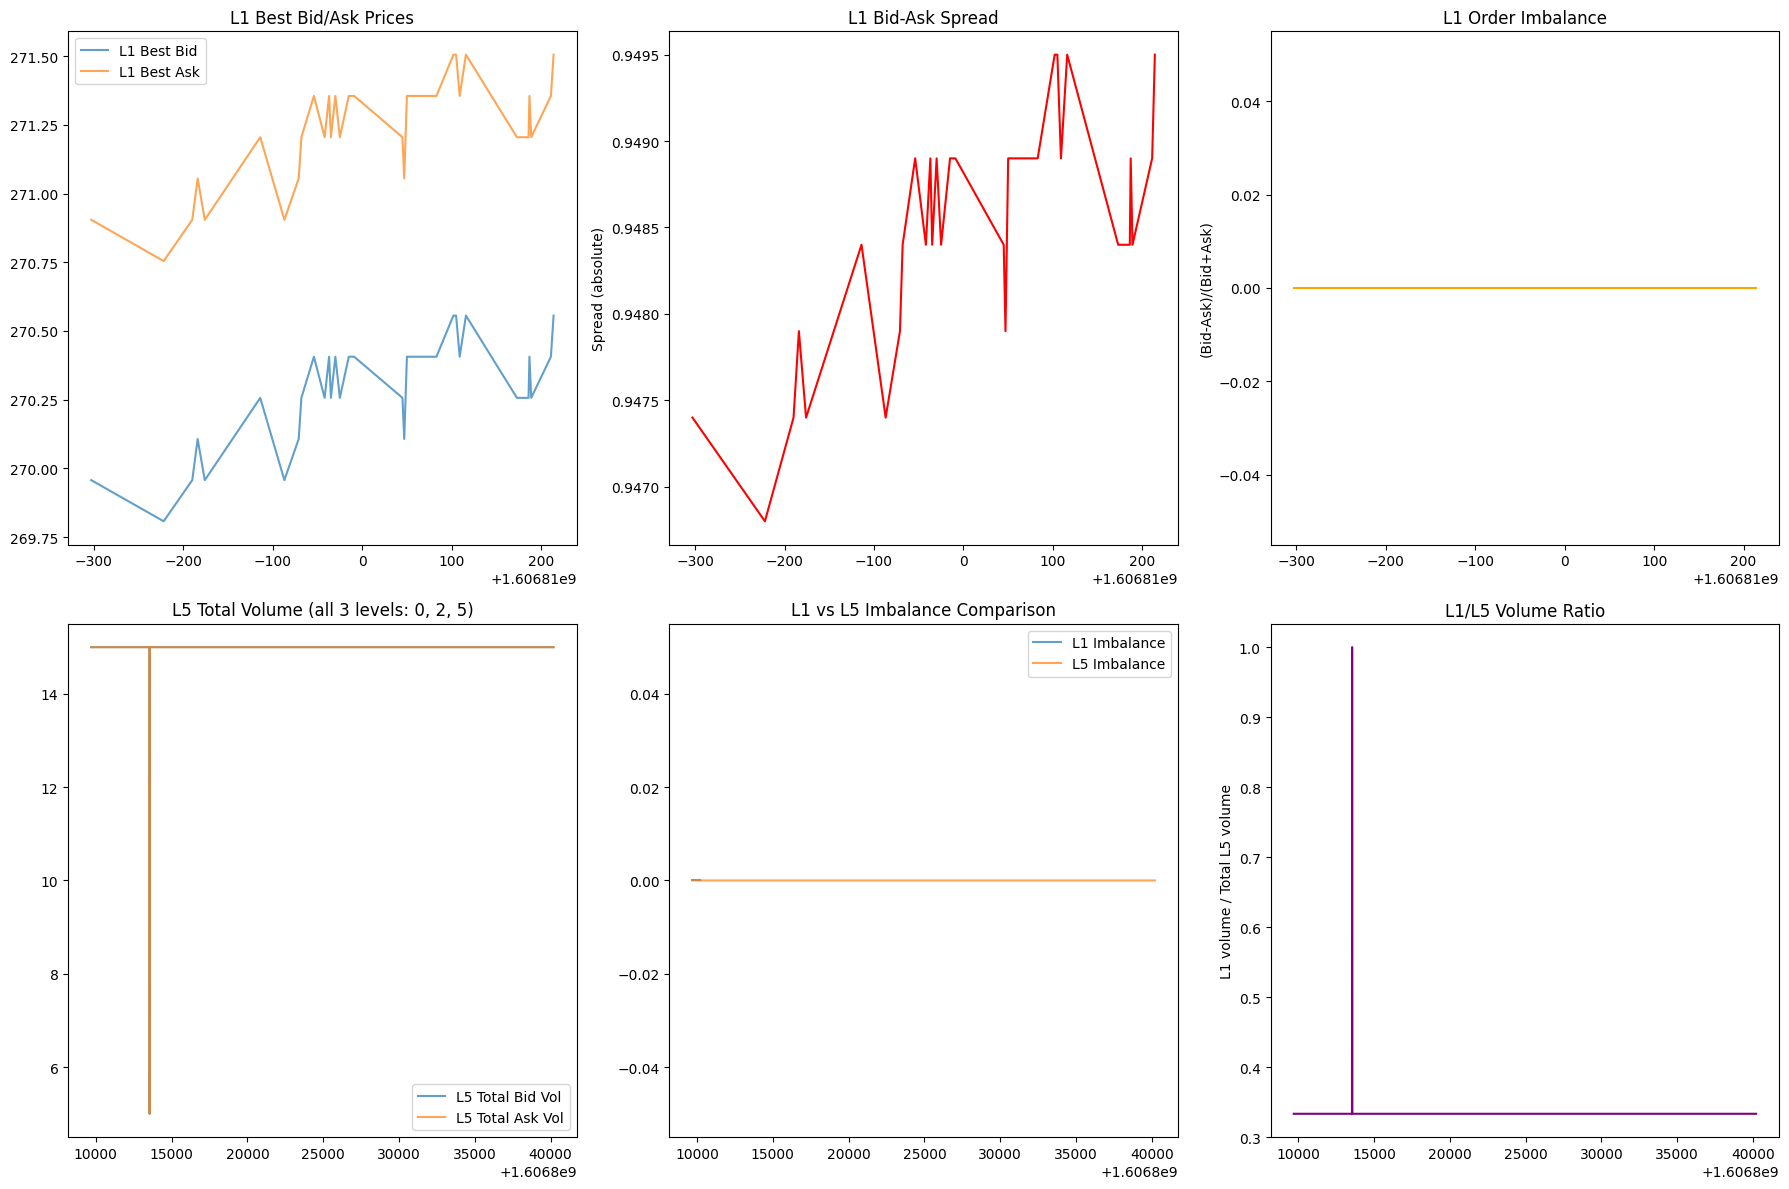


📈 L1 Summary Statistics:
       spread_abs  imbalance  microprice
count   33.000000       33.0   33.000000
mean     0.948518        0.0  270.762498
std      0.000699        0.0    0.201024
min      0.946800        0.0  270.280800
25%      0.948400        0.0  270.730700
50%      0.948400        0.0  270.730700
75%      0.948900        0.0  270.880650
max      0.949500        0.0  271.030550

🚀 L5 Enhanced Metrics Summary (3 levels: 0, 2, 5):
       total_bid_volume  total_ask_volume  imbalance_l5
count       2725.000000       2725.000000        2725.0
mean          14.996330         14.996330           0.0
std            0.191565          0.191565           0.0
min            5.000000          5.000000           0.0
25%           15.000000         15.000000           0.0
50%           15.000000         15.000000           0.0
75%           15.000000         15.000000           0.0
max           15.000000         15.000000           0.0


: 

In [ ]:
# === Visualization: L1 vs L5 Market Depth Analysis ===
# Compare liquidity metrics between L1 and L5 analysis
# NOTE: L5 captures all available depth in this dataset (levels 0, 2, 5)

import pandas as pd
import matplotlib.pyplot as plt

# Load both L1 and L5 aggregated data for comparison
try:
    l1_df = pd.read_csv(f"{REPO_DIR}/data_samples/48-FSTK-ADSG/l1/l1_agg_1s_seg48.csv")
    l5_df = pd.read_csv(f"{REPO_DIR}/data_samples/48-FSTK-ADSG/l5/l5_agg_1s_seg48.csv")
    
    print(f"📊 Loaded L1 data: {len(l1_df)} rows | L5 data: {len(l5_df)} rows")
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Basic L1 metrics
    axes[0,0].plot(l1_df['ts_s'], l1_df['best_bid'], label='L1 Best Bid', alpha=0.7)
    axes[0,0].plot(l1_df['ts_s'], l1_df['best_ask'], label='L1 Best Ask', alpha=0.7)
    axes[0,0].set_title('L1 Best Bid/Ask Prices')
    axes[0,0].legend()
    
    axes[0,1].plot(l1_df['ts_s'], l1_df['spread_abs'], label='L1 Spread', color='red')
    axes[0,1].set_title('L1 Bid-Ask Spread')
    axes[0,1].set_ylabel('Spread (absolute)')
    
    axes[0,2].plot(l1_df['ts_s'], l1_df['imbalance'], label='L1 Imbalance', color='orange')
    axes[0,2].set_title('L1 Order Imbalance')
    axes[0,2].set_ylabel('(Bid-Ask)/(Bid+Ask)')
    
    # Row 2: Enhanced L5 metrics (if available)
    if 'total_bid_volume' in l5_df.columns:
        axes[1,0].plot(l5_df['ts_s'], l5_df['total_bid_volume'], label='L5 Total Bid Vol', alpha=0.7)
        axes[1,0].plot(l5_df['ts_s'], l5_df['total_ask_volume'], label='L5 Total Ask Vol', alpha=0.7)
        axes[1,0].set_title('L5 Total Volume (all 3 levels: 0, 2, 5)')
        axes[1,0].legend()
        
        # Compare L1 vs L5 imbalance
        axes[1,1].plot(l1_df['ts_s'], l1_df['imbalance'], label='L1 Imbalance', alpha=0.7)
        if 'imbalance_l5' in l5_df.columns:
            axes[1,1].plot(l5_df['ts_s'], l5_df['imbalance_l5'], label='L5 Imbalance', alpha=0.7)
        axes[1,1].set_title('L1 vs L5 Imbalance Comparison')
        axes[1,1].legend()
        
        # Volume ratio analysis
        if 'volume_ratio_l1_to_l5' in l5_df.columns:
            axes[1,2].plot(l5_df['ts_s'], l5_df['volume_ratio_l1_to_l5'], color='purple')
            axes[1,2].set_title('L1/L5 Volume Ratio')
            axes[1,2].set_ylabel('L1 volume / Total L5 volume')
    else:
        for i in range(3):
            axes[1,i].text(0.5, 0.5, 'L5 data not available\nRun L5 construction first', 
                          ha='center', va='center', transform=axes[1,i].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📈 L1 Summary Statistics:")
    print(l1_df[['spread_abs', 'imbalance', 'microprice']].describe())
    
    if 'total_bid_volume' in l5_df.columns:
        print(f"\n🚀 L5 Enhanced Metrics Summary (3 levels: 0, 2, 5):")
        print(l5_df[['total_bid_volume', 'total_ask_volume', 'imbalance_l5']].describe())

except FileNotFoundError as e:
    print(f"⚠️  Data files not found: {e}")
    print("Please run the L1 and L5 construction and aggregation steps first.")